# 🔥 Ejemplo de Entrenamiento ViT con timm
Usando `timm` para entrenar un Vision Transformer sobre imágenes clasificadas del dataset FLAME.

In [1]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 50
best_acc = 0.0  # Para guardar el mejor modelo


In [5]:
# Transforms y Loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = datasets.ImageFolder("../data/Training", transform=transform)
val_ds = datasets.ImageFolder("../data/Test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

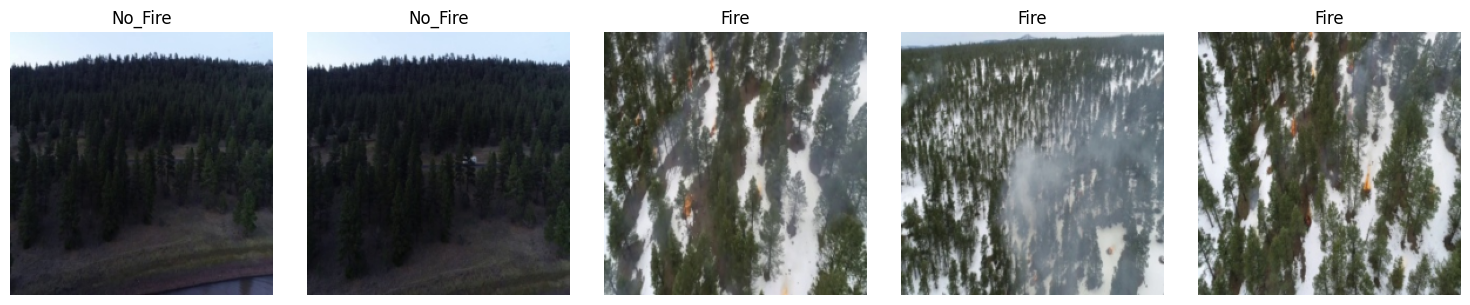

In [6]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
import random

# Transformación igual a la del entrenamiento (sin normalizar para visualización)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Ruta al dataset de entrenamiento
train_ds = datasets.ImageFolder("../data/Training", transform=transform)

# Seleccionar 5 imágenes aleatorias
indices = random.sample(range(len(train_ds)), 5)
samples = [train_ds[i] for i in indices]

# Mostrar las imágenes y sus clases
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, (img_tensor, label) in enumerate(samples):
    axs[i].imshow(to_pil_image(img_tensor))
    axs[i].set_title(train_ds.classes[label])
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [7]:
# modelo ViT desde timm
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Calcular pesos inversamente proporcionales a la frecuencia
fire_count = 25018
no_fire_count = 14357
total = fire_count + no_fire_count

# Ponderación: menos imágenes → mayor peso
weight_fire = total / (2 * fire_count)
weight_no_fire = total / (2 * no_fire_count)

weights = torch.tensor([weight_fire, weight_no_fire]).to(device)

# ✅ Función de pérdida ponderada
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizador
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Entrenamiento
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Evaluación en validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Guardar mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_swin_model_50.pth")
        print("Nuevo mejor modelo guardado.")


Epoch 1/50 | Loss: 0.0350 | Val Acc: 0.8400
Nuevo mejor modelo guardado.
Epoch 2/50 | Loss: 0.0211 | Val Acc: 0.8562
Nuevo mejor modelo guardado.
Epoch 3/50 | Loss: 0.0140 | Val Acc: 0.7828
Epoch 4/50 | Loss: 0.0124 | Val Acc: 0.8226
Epoch 5/50 | Loss: 0.0148 | Val Acc: 0.7621
Epoch 6/50 | Loss: 0.0189 | Val Acc: 0.7578
Epoch 7/50 | Loss: 0.0167 | Val Acc: 0.8732
Nuevo mejor modelo guardado.
Epoch 8/50 | Loss: 0.0103 | Val Acc: 0.8624
Epoch 9/50 | Loss: 0.0114 | Val Acc: 0.8289
Epoch 10/50 | Loss: 0.0087 | Val Acc: 0.8662
Epoch 11/50 | Loss: 0.0117 | Val Acc: 0.8541
Epoch 12/50 | Loss: 0.0090 | Val Acc: 0.8079
Epoch 13/50 | Loss: 0.0103 | Val Acc: 0.8403
Epoch 14/50 | Loss: 0.0110 | Val Acc: 0.8339
Epoch 15/50 | Loss: 0.0097 | Val Acc: 0.8502
Epoch 16/50 | Loss: 0.0105 | Val Acc: 0.7590
Epoch 17/50 | Loss: 0.0091 | Val Acc: 0.7923
Epoch 18/50 | Loss: 0.0099 | Val Acc: 0.7221
Epoch 19/50 | Loss: 0.0069 | Val Acc: 0.7209
Epoch 20/50 | Loss: 0.0104 | Val Acc: 0.7659
Epoch 21/50 | Loss: 0.

In [9]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(y.tolist())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

              precision    recall  f1-score   support

        Fire       0.76      0.91      0.82      5137
     No_Fire       0.81      0.57      0.67      3480

    accuracy                           0.77      8617
   macro avg       0.78      0.74      0.75      8617
weighted avg       0.78      0.77      0.76      8617



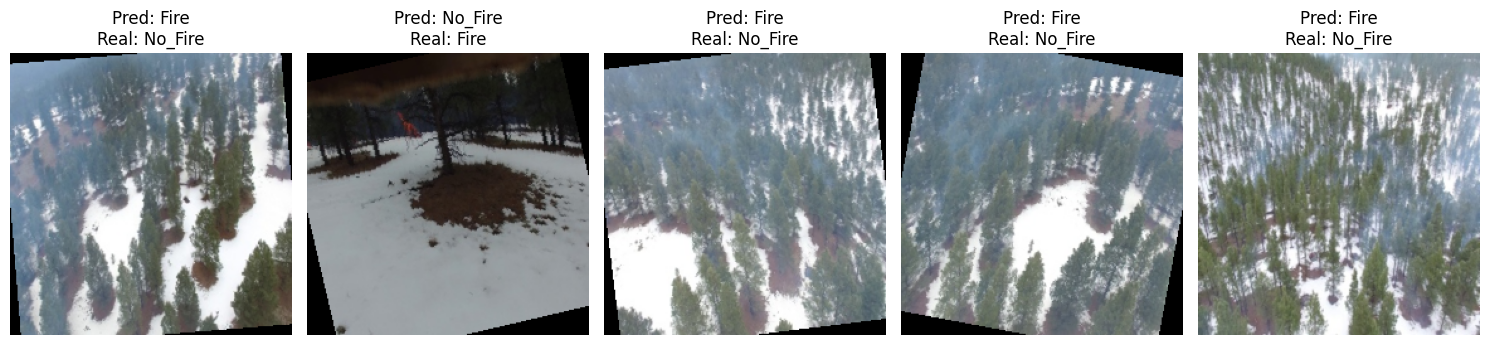

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# Función para desnormalizar (invierte Normalize([0.5]*3, [0.5]*3))
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Guardar imágenes mal clasificadas
wrong_samples = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred != true:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Seleccionar y mostrar 5 errores aleatorios (o menos si hay pocos)
n = min(5, len(wrong_samples))
samples_to_show = random.sample(wrong_samples, n)

# Mostrar visualmente
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(samples_to_show):
    img = denormalize(img_tensor)  # ✅ desnormalizar
    axs[i].imshow(to_pil_image(img))
    axs[i].set_title(f"Pred: {train_ds.classes[pred]}\nReal: {train_ds.classes[true]}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [33]:
print(train_ds.classes)  # ['Fire', 'No_Fire']


['Fire', 'No_Fire']


In [18]:
from PIL import Image

# Ruta de la imagen que quieres predecir
# image_path = "../data/Test/No_Fire/resized_test_nofire_frame22.jpg"
image_path = "../data/Test/Fire/resized_test_fire_frame5017.jpg"
# image_path = "../data/mydata/real_nofire1.jpg"

# Preprocesamiento (debe ser igual al del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Abrir imagen y preparar
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Inferen
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

#resultado
class_names = train_ds.classes  
print(f"La imagen fue clasificada como: {class_names[pred_class]}")

La imagen fue clasificada como: Fire


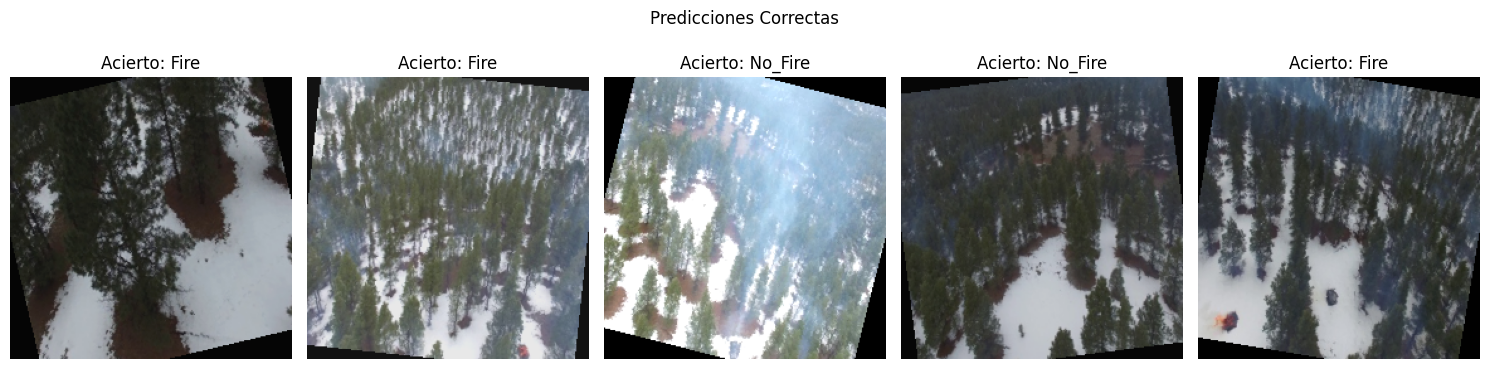

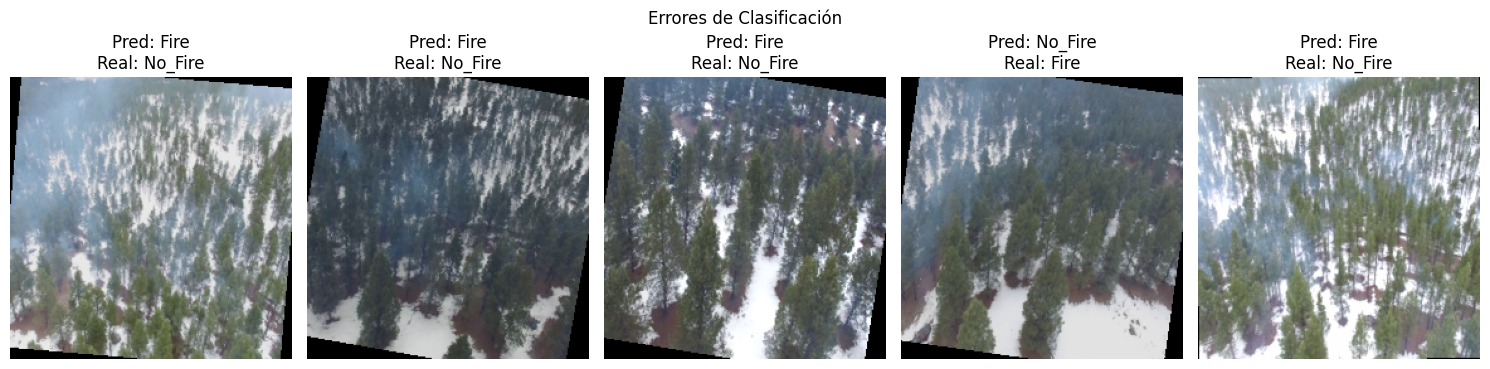

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random
import torch

# Función para desnormalizar
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # invierte Normalize([0.5]*3, [0.5]*3)

correct_samples = []
wrong_samples = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred == true:
                correct_samples.append((img_tensor.cpu(), pred.item(), true.item()))
            else:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Cantidad de muestras a mostrar
n = min(5, len(correct_samples), len(wrong_samples))
correct_show = random.sample(correct_samples, n)
wrong_show = random.sample(wrong_samples, n)

# Mostrar aciertos
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, _) in enumerate(correct_show):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Acierto: {train_ds.classes[pred]}")
    axs[i].axis("off")
plt.suptitle("Predicciones Correctas")
plt.tight_layout()
plt.show()

# Mostrar errores
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(wrong_show):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Pred: {train_ds.classes[pred]}\nReal: {train_ds.classes[true]}")
    axs[i].axis("off")
plt.suptitle("Errores de Clasificación")
plt.tight_layout()
plt.show()

In [28]:
from PIL import Image

# Ruta de la imagen que quieres predecir
# image_path = "../data/Test/No_Fire/resized_test_nofire_frame21.jpg"
# image_path = "../data/Test/Fire/resized_test_fire_frame5017.jpg"
image_path = "../data/mydata/aplao/fuego1.png"

# Preprocesamiento (debe ser igual al del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Abrir imagen y preparar
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Inferen
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

#resultado
class_names = train_ds.classes
print(f"La imagen fue clasificada como: {class_names[pred_class]}")

La imagen fue clasificada como: No_Fire


APLAO

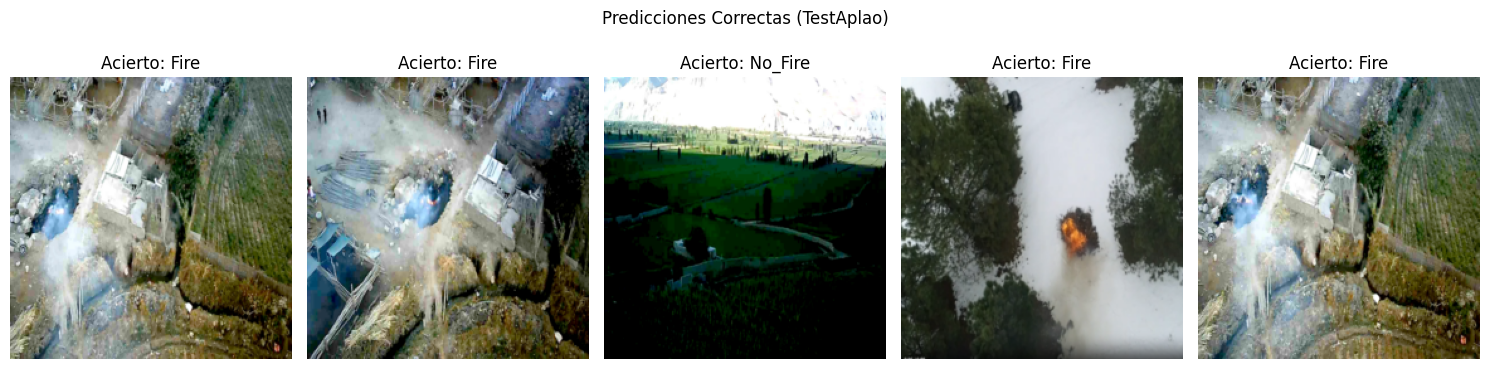

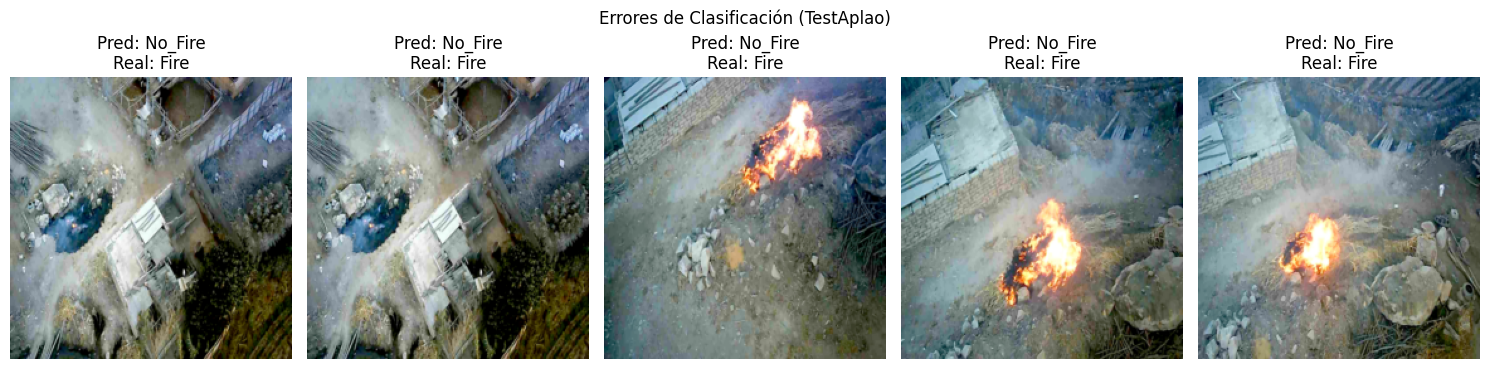

In [45]:
import torch
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Cargar modelo Swin-Tiny entrenado ---
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("best_swin_model.pth", map_location=device))
model.to(device)
model.eval()
# swin_base_patch4_window7_224
# --- 2. Definir transformaciones y DataLoader externo ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Ruta con subcarpetas Fire/ y No_Fire/
external_dataset = datasets.ImageFolder("../data/mydata/aplao", transform=transform)
external_loader = DataLoader(external_dataset, batch_size=16, shuffle=False)

# --- 3. Evaluar y visualizar ---
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

correct_samples = []
wrong_samples = []

with torch.no_grad():
    for x, y in external_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred == true:
                correct_samples.append((img_tensor.cpu(), pred.item(), true.item()))
            else:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Mostrar 5 ejemplos de aciertos
n = min(5, len(correct_samples))
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, _) in enumerate(random.sample(correct_samples, n)):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Acierto: {external_dataset.classes[pred]}")
    axs[i].axis("off")
plt.suptitle("Predicciones Correctas (TestAplao)")
plt.tight_layout()
plt.show()

# Mostrar 5 ejemplos de errores
n = min(5, len(wrong_samples))
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(random.sample(wrong_samples, n)):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Pred: {external_dataset.classes[pred]}\nReal: {external_dataset.classes[true]}")
    axs[i].axis("off")
plt.suptitle("Errores de Clasificación (TestAplao)")
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import timm

# Cargar modelo
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("best_swin_model_50.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
# Leer video
cap = cv2.VideoCapture("../data/mydata/aplao/WhatsApp Video 2025-07-07 at 11.18.31 PM.mp4")
# cap = cv2.VideoCapture("../generaldata/2-Zenmuse_X4S_2.mp4")
# WhatsApp Video 2025-07-09 at 8.02.29 PM
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Crear nuevo video
out = cv2.VideoWriter("../data/mydata/videosprocesados/WhatsApp Video 2025-07-07 at 11.18.31 PM SALIDA SWIN 6.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Clasificar frame
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()

    # Mostrar resultado en frame
    label = "FIRE" if pred == 0 else "NO FIRE"
    color = (0, 0, 255) if label == "FIRE" else (0, 255, 0)

    cv2.putText(frame, f"Pred: {label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

    # Escribir frame en nuevo video
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()

In [48]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import timm
import numpy as np
from collections import deque
import torch.nn.functional as F

# Configuración
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WINDOW_SIZE = 5
FIRE_THRESHOLD = 0.7

# Cargar modelo
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("best_swin_model_50_tinny.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Video
cap = cv2.VideoCapture("../data/mydata/aplao/APLAO TOP 4.mp4")
# cap = cv2.VideoCapture("../generaldata/2-Zenmuse_X4S_2.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Salida
out = cv2.VideoWriter("../data/mydata/videosprocesados/APLAO TOP 4 SWIN TINY PERC GR.mp4",
                      cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

# Ventanas deslizantes
recent_preds = deque(maxlen=WINDOW_SIZE)
recent_probs = deque(maxlen=WINDOW_SIZE)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).cpu().numpy()[0]

    pred = int(np.argmax(probs))
    prob_pred = probs[pred]

    recent_preds.append(pred)
    recent_probs.append(prob_pred)

    # ---------------- VISUALIZACIÓN ---------------- #
    label = "FIRE" if pred == 0 else "NO FIRE"
    avg_prob = np.mean(recent_probs) * 100
    color = (0, 0, 255) if label == "FIRE" else (0, 255, 0)
    text = f"Prediccion: {label} ({avg_prob:.1f}%)"

    # Dibujar fondo transparente para el texto
    overlay = frame.copy()
    cv2.rectangle(overlay, (20, 20), (450, 110), (0, 0, 0), -1)
    frame = cv2.addWeighted(overlay, 0.4, frame, 0.6, 0)

    # Texto principal
    cv2.putText(frame, text, (30, 60), cv2.FONT_HERSHEY_SIMPLEX,
                1.2, color, 2, cv2.LINE_AA)

    # Decisión basada en ventana
    if len(recent_preds) == WINDOW_SIZE:
        fire_ratio = recent_preds.count(0) / WINDOW_SIZE
        decision = "FUEGO DETECTADO" if fire_ratio >= FIRE_THRESHOLD else "NO FUEGO"
        decision_color = (0, 0, 255) if fire_ratio >= FIRE_THRESHOLD else (0, 255, 0)
        cv2.putText(frame, decision, (30, 100), cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, decision_color, 2, cv2.LINE_AA)

    # Texto de ubicación (abajo derecha)
    location_text = "Aplao - Arequipa"
    (text_w, text_h), _ = cv2.getTextSize(location_text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
    cv2.putText(frame, location_text, (width - text_w - 20, height - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

Ejemplo de salida de probabilidades:
Clase FIRE (0): 0.0005890355678275228
Clase NO FIRE (1): 0.9994109869003296


c:\Users\TestUser\Documents\MAESTRIA\vit_env\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


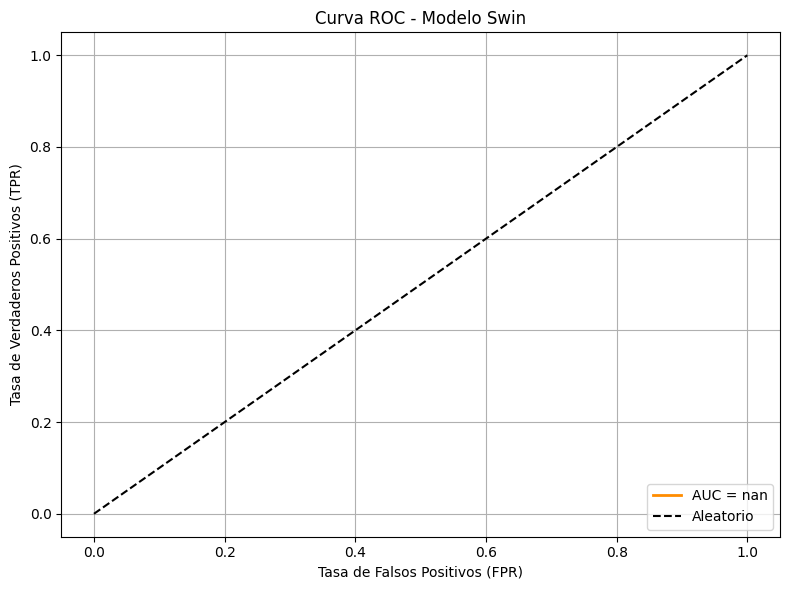

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Configurar dispositivo ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Cargar modelo entrenado ---
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("best_swin_model_50_tinny.pth", map_location=device))
model.to(device)
model.eval()

# --- 3. Dataset y DataLoader (usa TEST aquí si deseas evaluar generalización) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_dataset = datasets.ImageFolder("../data/Test", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- 4. Recolectar probabilidades y etiquetas ---
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        probs = F.softmax(outputs, dim=1)  # 🔥 Probabilidades para ambas clases (FIRE y NO FIRE)
        all_probs.extend(probs[:, 0].cpu().numpy())  # 🔴 Solo prob. clase 0 (FIRE)
        all_labels.extend(y.cpu().numpy())

        # Mostrar ejemplo de probabilidades por batch (opcional)
        print("Ejemplo de salida de probabilidades:")
        print("Clase FIRE (0):", probs[0, 0].item())
        print("Clase NO FIRE (1):", probs[0, 1].item())
        break  # ⚠️ Elimina este 'break' si quieres imprimir más de un ejemplo

# --- 5. Calcular curva ROC y AUC ---
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# --- 6. Graficar curva ROC ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Swin')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Distribución de clases: Counter({0: 5137, 1: 3480})
Clases: ['Fire', 'No_Fire']


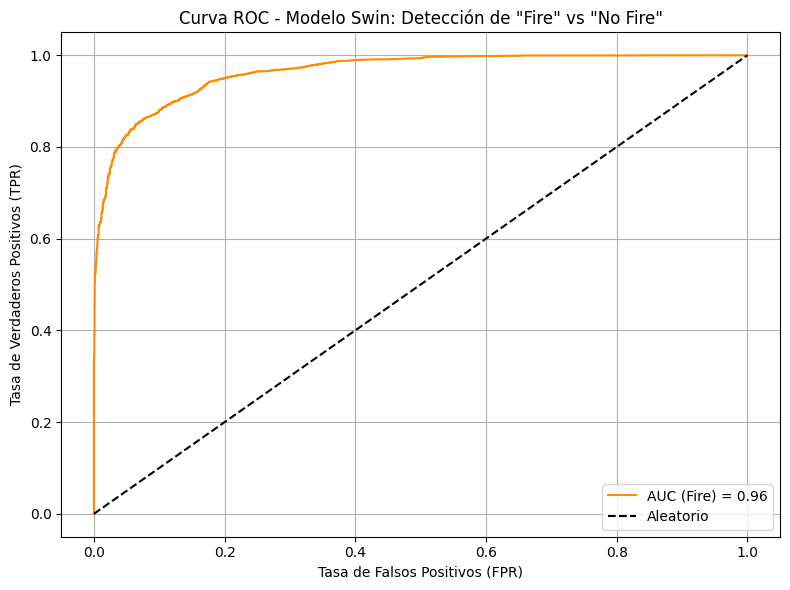

In [55]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter

# --- 1. Configurar dispositivo ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Cargar modelo Swin entrenado ---
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("best_swin_model_50_tinny.pth", map_location=device))
model.to(device)
model.eval()

# --- 3. DataLoader para conjunto de prueba ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_dataset = datasets.ImageFolder("../data/Test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 4. Calcular probabilidades y etiquetas ---
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        probs = F.softmax(outputs, dim=1)  # Clase 0: Fire, Clase 1: No Fire

        all_probs.extend(probs[:, 0].cpu().numpy())   # Probabilidad de clase "Fire"
        all_labels.extend(y.cpu().numpy())

# --- 5. Verificar clases presentes ---
class_counts = Counter(all_labels)
print("Distribución de clases:", class_counts)
print("Clases:", test_dataset.classes)

if len(set(all_labels)) < 2:
    print("⚠️ Advertencia: Solo se encontró una clase en el conjunto de prueba. No se puede calcular la curva ROC.")
else:
    # --- 6. Calcular curva ROC y AUC ---
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=0)  # Clase 0 es "Fire"
    roc_auc = auc(fpr, tpr)

    # --- 7. Graficar curva ROC ---
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", label=f'AUC (Fire) = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC - Modelo Swin: Detección de "Fire" vs "No Fire"')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [50]:
print("Ejemplo de salida de probabilidad:")
print("Clase 0 (FIRE):", probs[0])
print("Clase 1 (NO FIRE):", probs[1])

Ejemplo de salida de probabilidad:
Clase 0 (FIRE): tensor(2.1491e-05, device='cuda:0')
Clase 1 (NO FIRE): tensor(2.0676e-05, device='cuda:0')


In [54]:
from torchvision import datasets, transforms
from collections import Counter

# Dataset transform básico
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Cargar dataset
dataset = datasets.ImageFolder("../data/Test", transform=transform)

# Mostrar la distribución de clases
labels = [label for _, label in dataset]
print("Distribución de clases:", Counter(labels))
print("Clases:", dataset.classes)

Distribución de clases: Counter({0: 5137, 1: 3480})
Clases: ['Fire', 'No_Fire']


In [ ]:
import cv2
import os

# Ruta al video
video_path = "../generaldata/2-Zenmuse_X4S_2.mp4"

# Ruta de salida (carpeta donde guardarás las imágenes)
output_folder = "../data/Training/Fire"  # o ../data/Training/No_Fire

# Crear carpeta si no existe
os.makedirs(output_folder, exist_ok=True)

# Cargar video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)  # frames por segundo

# # Tiempo a frame (en segundos)
# start_time = 50    # 00:50 → 50 segundos
# end_time = 197     # 03:17 → 3*60 + 17 = 197 segundos

start_time = 5 * 60 + 15   # 05:15 → 315 segundos
end_time = 6 * 60 + 30     # 06:30 → 390 segundos

start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

frame_number = 0
saved_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_number > end_frame:
        break

    if start_frame <= frame_number <= end_frame:
        output_path = os.path.join(output_folder, f"frame_1{frame_number}.jpg")
        cv2.imwrite(output_path, frame)
        saved_count += 1

    frame_number += 1

cap.release()
print(f"✅ {saved_count} frames guardados en: {output_folder}")


✅ 2123 frames guardados en: ../data/Training/Fire


In [33]:
torch.save(model.state_dict(), "best_swin_model_50_tinny.pth")